Import nesessary libraries and modules

In [1]:
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
    sys.path.append(os.path.realpath("../../"))
import time
import json
import math

from keras.models import model_from_json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import ntpath
import glob
import deepconfig

import keras
from keras.models import Model
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import mnist
from keras import backend as K
from keras.utils import np_utils
from IPython.display import Image, display
from CMS_SURF_2016.utils.callbacks import OverfitStopping

from functions import*
from functions import MyFigure

dc = deepconfig.deepconfig(gpu='gpu0', backend='theano')

batch_size = 100

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.
using gpu0
using theano


Load models from files

In [3]:
bottlenecks = [2,4,6,8,16,32,64,128]
layers = [1,2,3,4,5]
results = {}
for nLayers in layers:
    results[nLayers] = {}
    for nBottleneck in bottlenecks:
        if (nBottleneck == 32) and (nLayers == 4):
            continue
        else:  
            aeFile = glob.glob('/data/shared/MNIST/autoencoder_%s_%s_model*.json' % (nLayers, nBottleneck))
            aeWeight = glob.glob('/data/shared/MNIST/autoencoder_%s_%s_model*.hdf5' % (nLayers, nBottleneck))
            
            codFile = glob.glob('/data/shared/MNIST/encoder_%s_%s_model*.json' % (nLayers, nBottleneck))
            codWeight = glob.glob('/data/shared/MNIST/encoder_%s_%s_model*.hdf5' % (nLayers, nBottleneck))
            
            decFile = glob.glob('/data/shared/MNIST/decoder_%s_%s_model*.json' % (nLayers, nBottleneck))
            decWeight = glob.glob('/data/shared/MNIST/decoder_%s_%s_model*.hdf5' % (nLayers, nBottleneck))
            
            for i in range (0,len(aeFile)):
                ae = model_from_json(open(aeFile[i]).read())
                ae.load_weights(aeWeight[i])
                ae.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])
                #print ae.summary()
                
                cod = model_from_json(open(codFile[i]).read())
                cod.load_weights(codWeight[i])
                cod.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])
                #print cod.summary()
                
                dec = model_from_json(open(decFile[i]).read())
                dec.load_weights(decWeight[i])
                dec.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])
                #print cod.summary()
            
                results[nLayers][nBottleneck] = {'Autoencoder':ae,
                                                'Coder': cod,
                                                'Decoder': dec}

Save the topology of the models

In [4]:
from keras.utils.visualize_util import plot
for layer, model in results.iteritems():
    for bottleneck in model:
        image_name = '/home/olgalyu/CMS_SURF_2016/MNIST_Analysis/Model_topologies/Model[%s_%s].png' % (layer,bottleneck)
        dot = plot(results[layer][bottleneck]['Autoencoder'], to_file=image_name, show_shapes=True, show_layer_names=False)
        display()

Calculate accuracy of the models

In [29]:
x_train, y_train, x_train_outlier, y_train_outlier, x_test, y_test, x_test_outlier, y_test_outlier = setData(7)
modelLayers = []
modelBottleneck = []
modelAcc = []
for layer, model in results.iteritems():
    for bottleneck in model:
        ae = model[bottleneck]['Autoencoder'] 
        score = ae.evaluate(x_test, x_test, verbose=0)
        modelLayers.append(layer)
        modelBottleneck.append(bottleneck)
        modelAcc.append(score[1]*100)
        print 'Model [%s_%s] %s: %.2f%%' % (layer, bottleneck, ae.metrics_names[1], score[1]*100)
modelAccData = zip(modelLayers,modelBottleneck,modelAcc)

Model [1_32] acc: 1.00%
Model [1_64] acc: 1.21%
Model [1_2] acc: 1.00%
Model [1_4] acc: 0.98%
Model [1_6] acc: 1.05%
Model [1_8] acc: 1.21%
Model [1_128] acc: 1.52%
Model [1_16] acc: 1.06%
Model [2_32] acc: 1.17%
Model [2_64] acc: 1.56%
Model [2_2] acc: 0.79%
Model [2_4] acc: 0.98%
Model [2_6] acc: 1.25%
Model [2_8] acc: 1.27%
Model [2_128] acc: 1.25%
Model [2_16] acc: 1.34%
Model [3_32] acc: 1.03%
Model [3_64] acc: 1.54%
Model [3_2] acc: 0.82%
Model [3_4] acc: 0.85%
Model [3_6] acc: 0.95%
Model [3_8] acc: 1.00%
Model [3_128] acc: 1.08%
Model [3_16] acc: 1.20%
Model [4_64] acc: 1.42%
Model [4_128] acc: 1.04%
Model [4_2] acc: 0.78%
Model [4_4] acc: 0.98%
Model [4_6] acc: 1.10%
Model [4_8] acc: 1.15%
Model [4_16] acc: 1.52%
Model [5_32] acc: 1.27%
Model [5_64] acc: 1.40%
Model [5_2] acc: 0.82%
Model [5_4] acc: 1.46%
Model [5_6] acc: 0.89%
Model [5_8] acc: 1.10%
Model [5_128] acc: 1.65%
Model [5_16] acc: 1.25%


Calculate some characteristics of models

In [6]:
for layer, model in results.iteritems():
    for bottleneck in model:
        info = model[bottleneck]
        print 'Model [%s_%s]' % (layer, bottleneck)
        pixels = np.where(x_test > 0.99)[0]
        pixels_outlier = np.where(x_test_outlier > 0.99)[0]
        
        info['Loss'],info['Acc'] = info['Autoencoder'].evaluate(x_test, x_test, batch_size=batch_size)
        prediction = info['Autoencoder'].predict(x_test)

        info['Loss_outlier'],info['Acc_outlier'] = info['Autoencoder'].evaluate(x_test_outlier,x_test_outlier, batch_size=batch_size)
        prediction_outlier = info['Autoencoder'].predict(x_test_outlier)

        info['MSE'] = np.sqrt(np.mean( (prediction[pixels]-x_test[pixels])**2,axis=1)) 
        info['MSE_outlier'] = np.sqrt(np.mean( (prediction_outlier[pixels_outlier]-x_test_outlier[pixels_outlier])**2,axis=1))

        info['MD'] = np.mean( (prediction-x_test),axis=1) 
        info['MD_outlier'] = np.mean( (prediction_outlier-x_test_outlier),axis=1)
        
        info['MDP'] = np.mean( (prediction[pixels]-x_test[pixels]),axis=1) 
        info['MDP_outlier'] = np.mean( (prediction_outlier[pixels_outlier]-x_test_outlier[pixels_outlier]),axis=1)
        
        info['NumberParam'] = info['Autoencoder'].count_params()
        print ' '

Model [1_32]
 800/1028 [======================>.......] - ETA: 0s 
Model [1_64]
 900/1028 [=========================>....] - ETA: 0s 
Model [1_2]
 900/1028 [=========================>....] - ETA: 0s 
Model [1_4]
 900/1028 [=========================>....] - ETA: 0s 
Model [1_6]
 900/1028 [=========================>....] - ETA: 0s 
Model [1_8]
 900/1028 [=========================>....] - ETA: 0s 
Model [1_128]
 900/1028 [=========================>....] - ETA: 0s 
Model [1_16]
 900/1028 [=========================>....] - ETA: 0s 
Model [2_32]
 800/1028 [======================>.......] - ETA: 0s 
Model [2_64]
 900/1028 [=========================>....] - ETA: 0s 
Model [2_2]
 800/1028 [======================>.......] - ETA: 0s 
Model [2_4]
 800/1028 [======================>.......] - ETA: 0s 
Model [2_6]
 900/1028 [=========================>....] - ETA: 0s 
Model [2_8]
 900/1028 [=========================>....] - ETA: 0s 
Model [2_128]
1028/1028 [==============================] - 0s     
 


Show info about each model

In [7]:
for layer, model in results.iteritems():
    for bottleneck in model:
        print 'Model [%s_%s]' % (layer, bottleneck)
        showInfo(results[layer][bottleneck])
        print ' '

Model [1_32]
Acc 0.0100312079824
Acc_outlier 0.00972762624171
Loss 0.0185364289463
Loss_outlier 0.0203256943781
MSE [ 0.13816513  0.13816513  0.13816513 ...,  0.17266847  0.17266847
  0.17266847]
MSE_outlier [ 0.14626175  0.14626175  0.14626175 ...,  0.13524054  0.13524054
  0.13524054]
MD [-0.01271511 -0.00069249 -0.01272051 ..., -0.00668016 -0.0101292  -0.0166703 ]
MD_outlier [-0.01510443 -0.01310612 -0.01278234 ..., -0.00900452 -0.01516456
 -0.00887251]
MDP [-0.01271511 -0.01271511 -0.01271511 ..., -0.0166703  -0.0166703  -0.0166703 ]
MDP_outlier [-0.01510443 -0.01510443 -0.01510443 ..., -0.00887251 -0.00887251
 -0.00887251]
NumberParam 667488
 
Model [1_64]
Acc 0.0121489074413
Acc_outlier 0.0136186769196
Loss 0.0157099452556
Loss_outlier 0.0158492157178
MSE [ 0.15196769  0.15196769  0.15196769 ...,  0.17544098  0.17544098
  0.17544098]
MSE_outlier [ 0.12156875  0.12156875  0.12156875 ...,  0.12749285  0.12749285
  0.12749285]
MD [-0.02111454 -0.00606632 -0.00736425 ..., -0.00829037

Get MSE plots

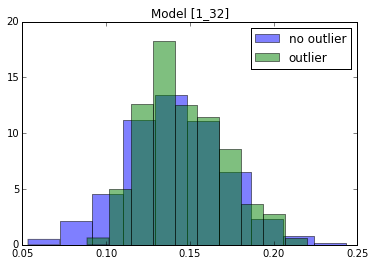

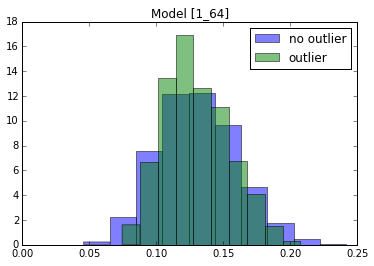

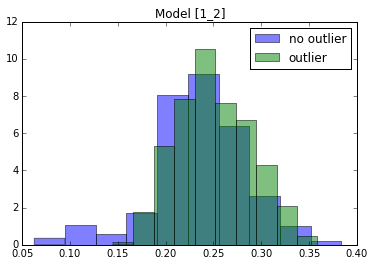

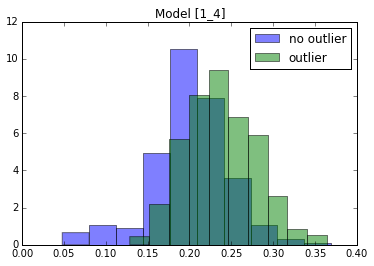

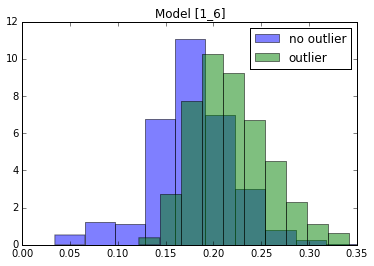

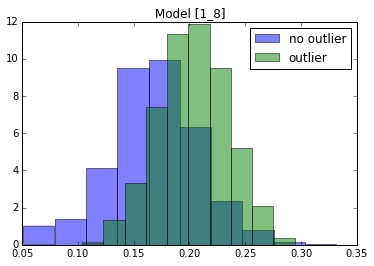

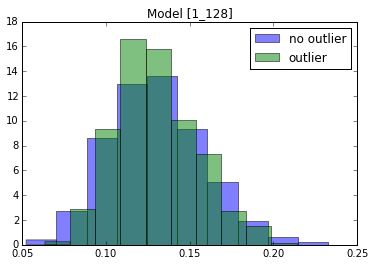

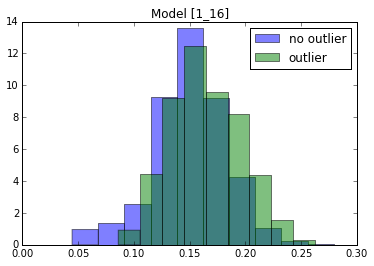

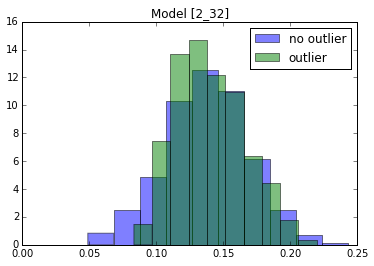

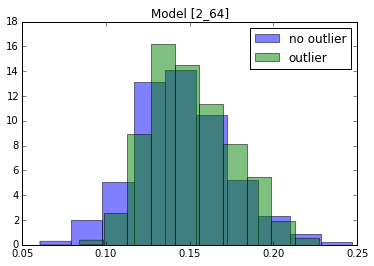

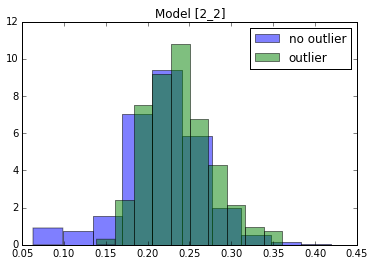

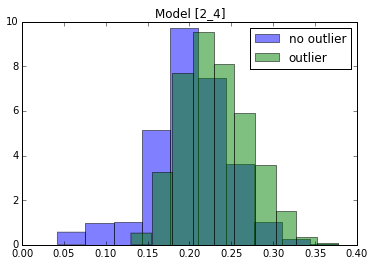

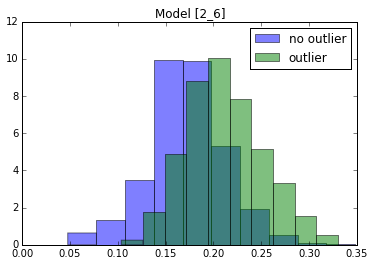

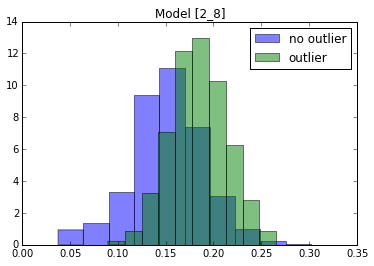

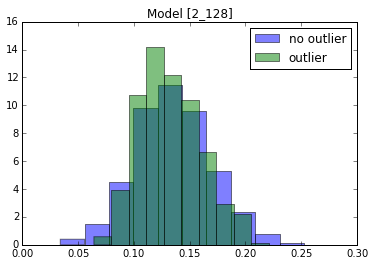

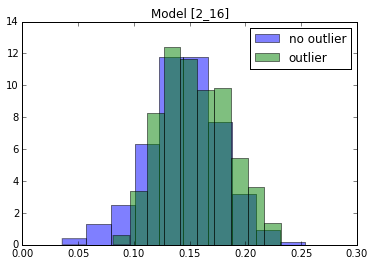

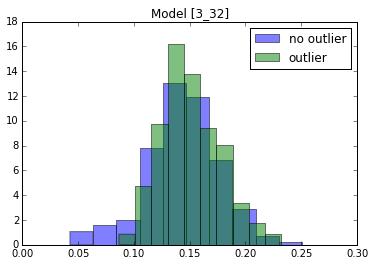

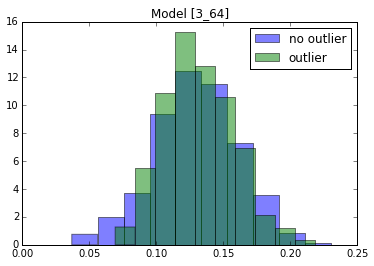

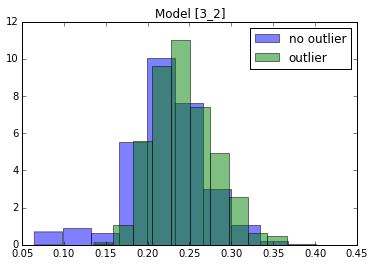

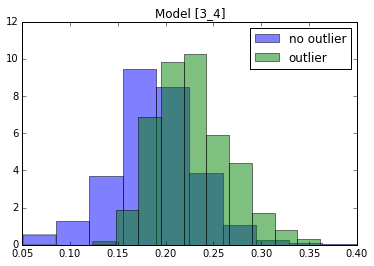

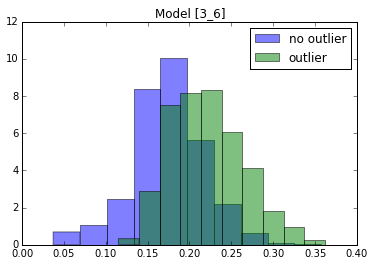

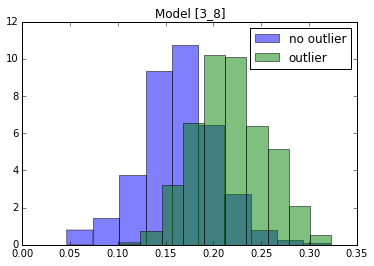

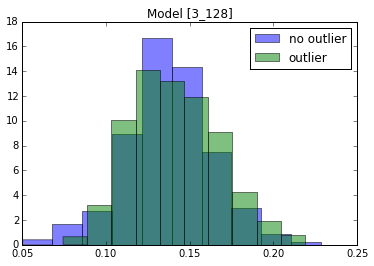

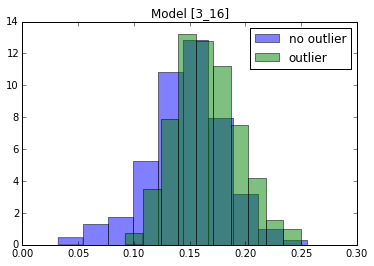

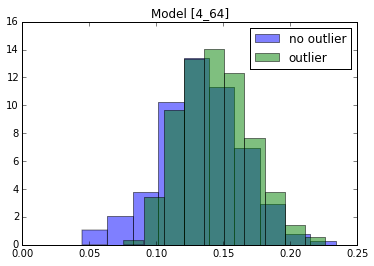

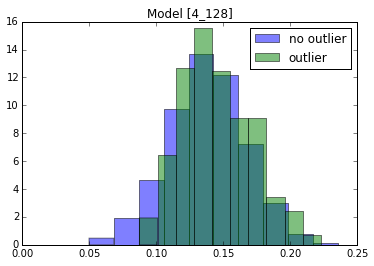

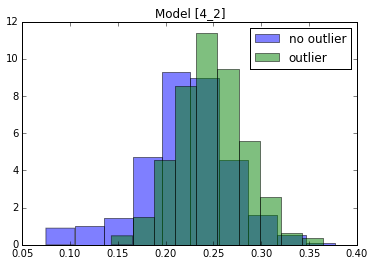

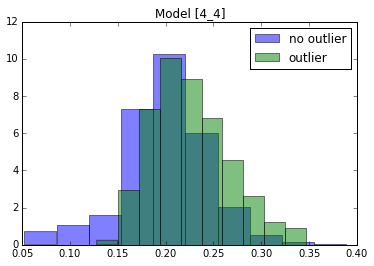

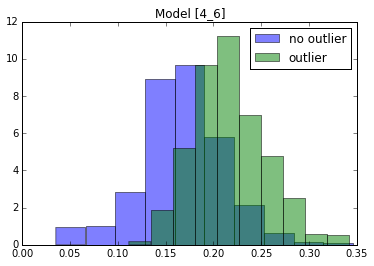

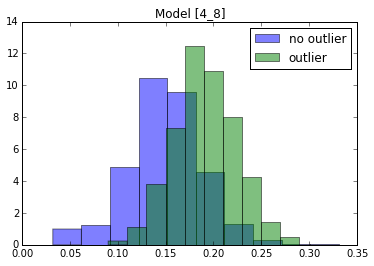

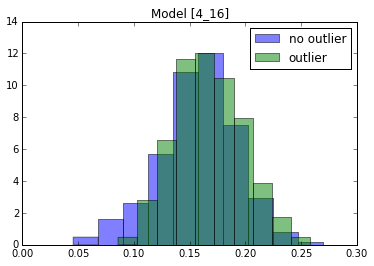

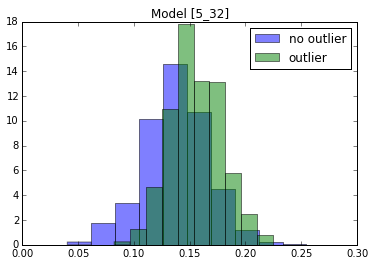

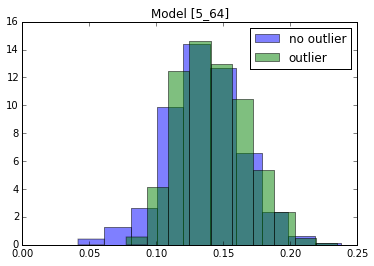

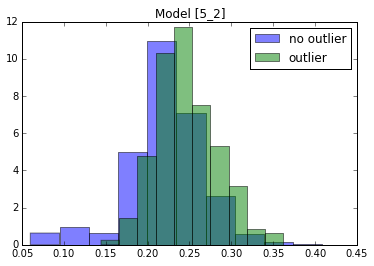

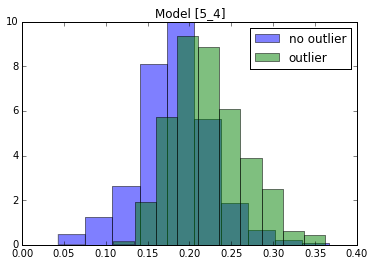

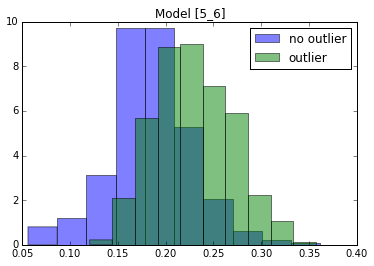

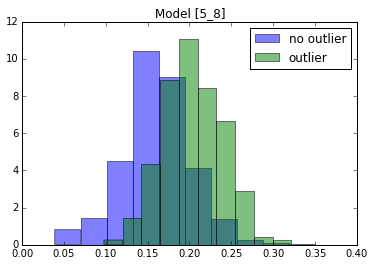

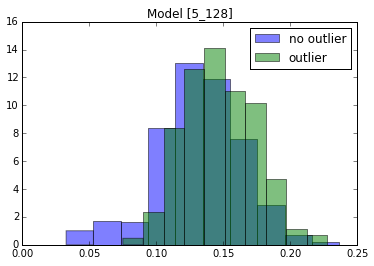

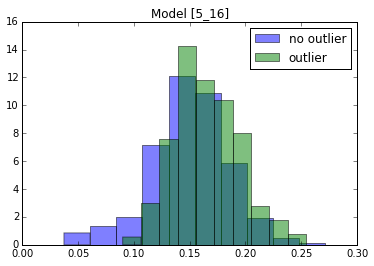

In [8]:
for layer, model in results.iteritems():
    for bottleneck in model:
        plt.hist( results[layer][bottleneck]['MSE'], alpha=0.5, label='no outlier', normed=1)
        plt.hist( results[layer][bottleneck]['MSE_outlier'], alpha=0.5, label='outlier',normed=1)
        plt.title('Model [%s_%s]' % (layer, bottleneck))
        plt.legend()
        plt.show()

Get MD plots

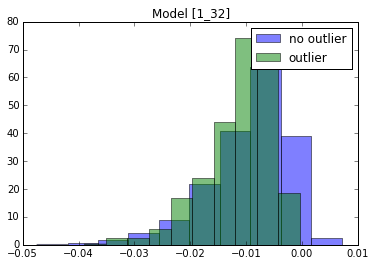

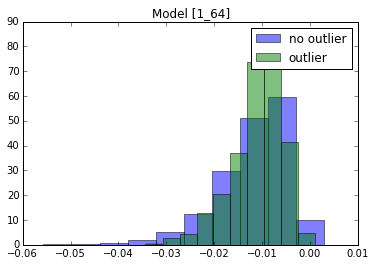

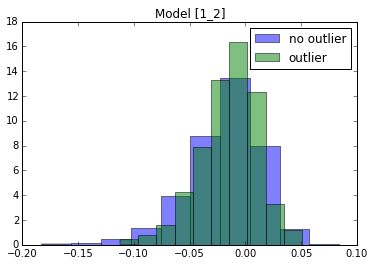

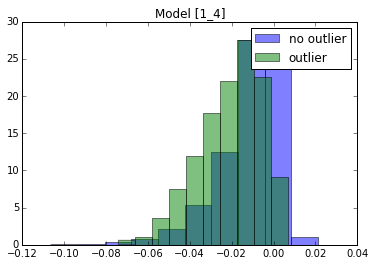

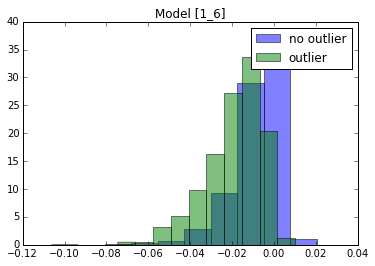

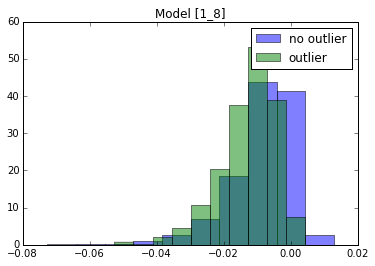

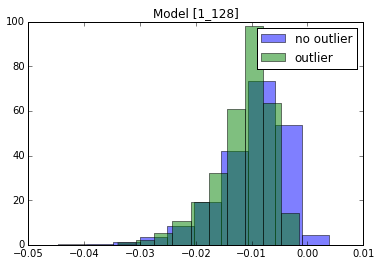

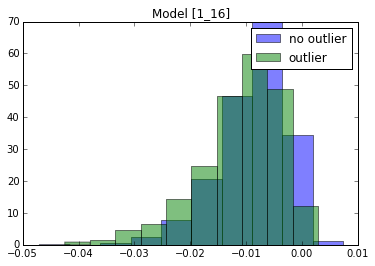

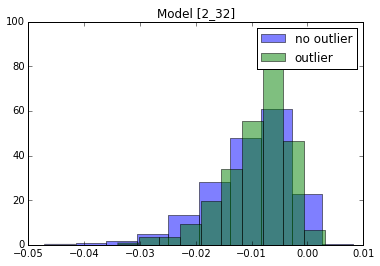

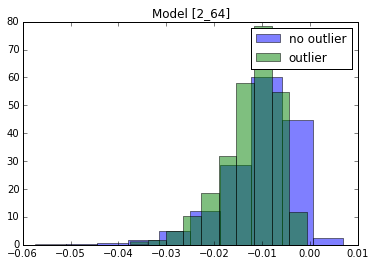

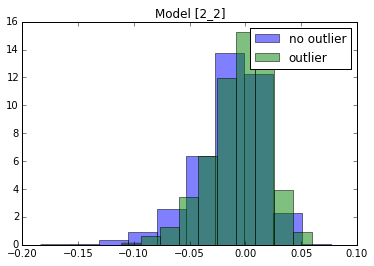

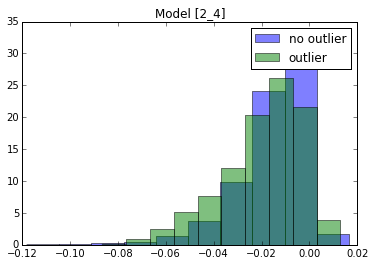

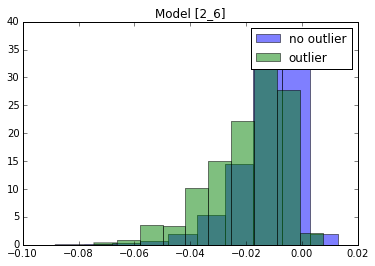

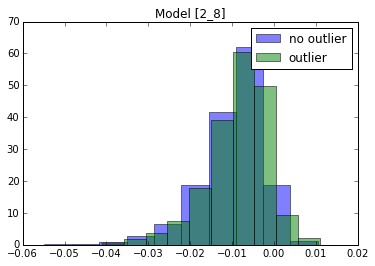

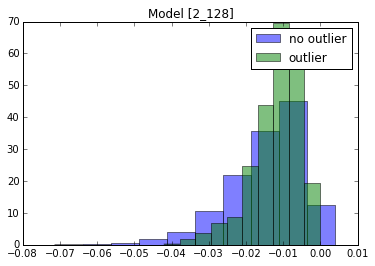

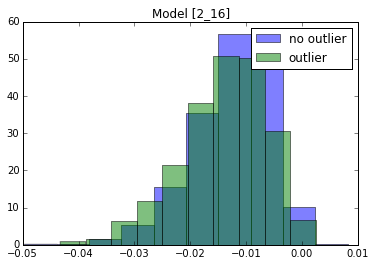

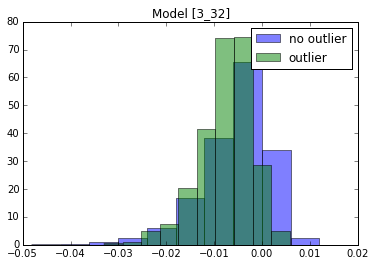

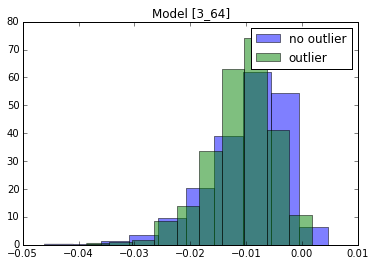

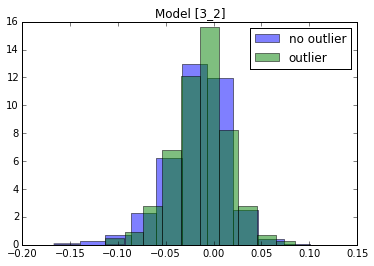

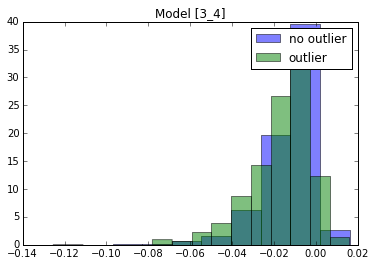

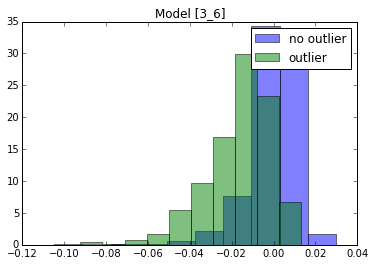

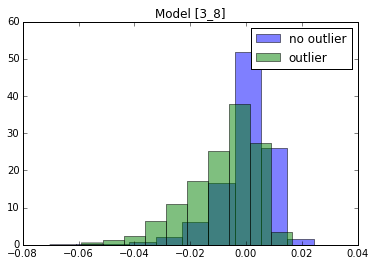

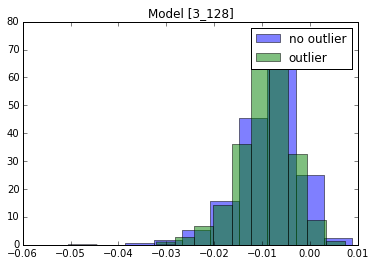

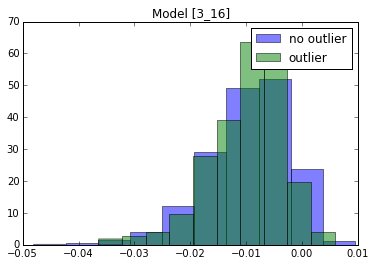

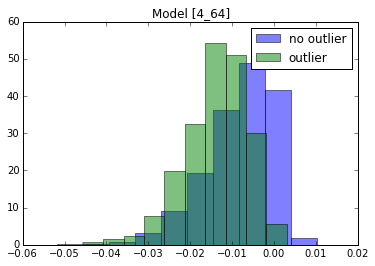

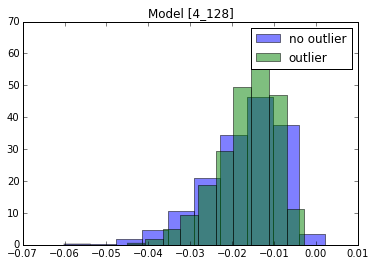

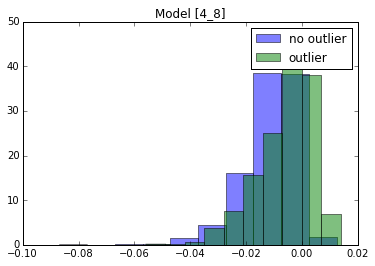

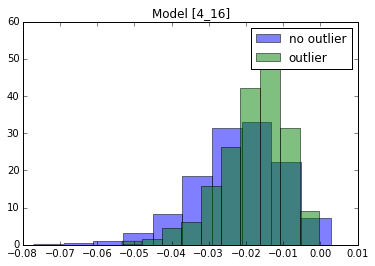

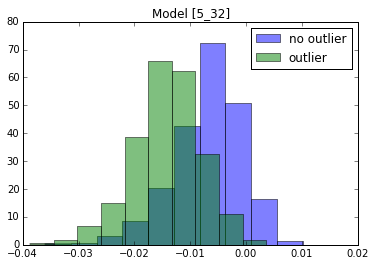

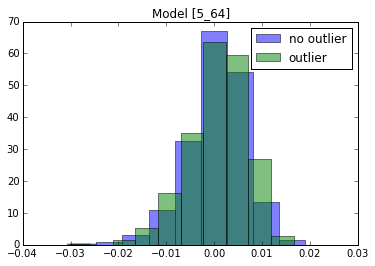

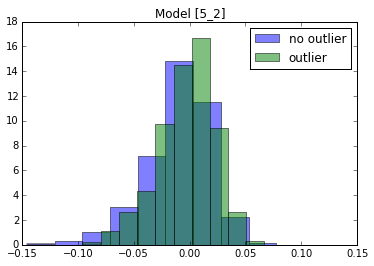

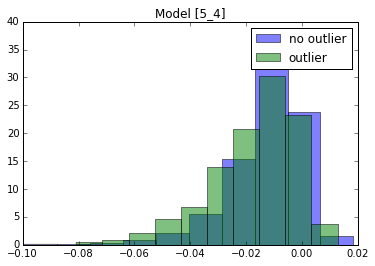

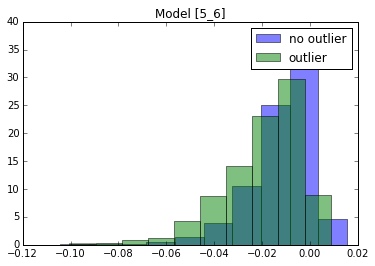

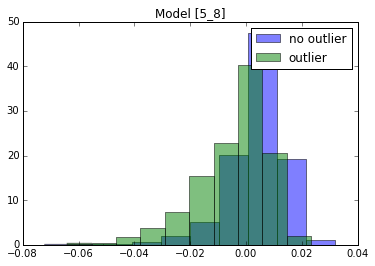

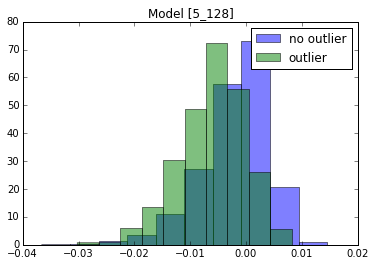

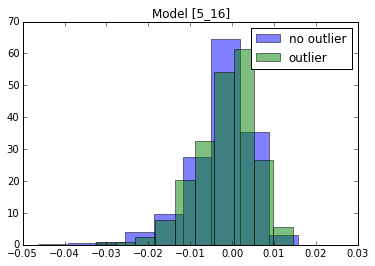

In [9]:
for layer, model in results.iteritems():
    for bottleneck in model:
        plt.hist( results[layer][bottleneck]['MD'], alpha=0.5, label='no outlier', normed=1)
        plt.hist( results[layer][bottleneck]['MD_outlier'], alpha=0.5, label='outlier',normed=1)
        plt.title('Model [%s_%s]' % (layer, bottleneck))
        plt.legend()
        plt.show()

Get MDP plots

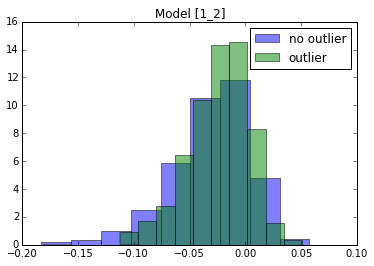

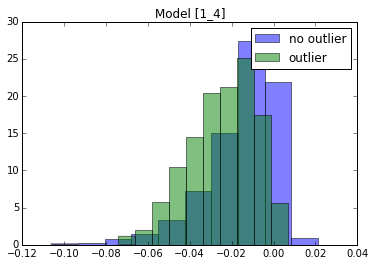

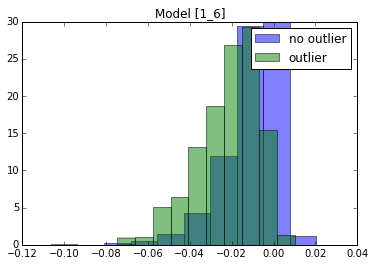

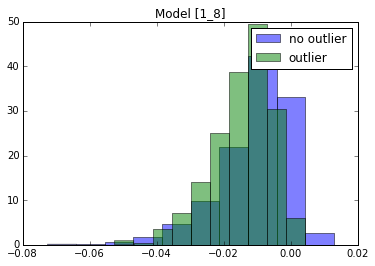

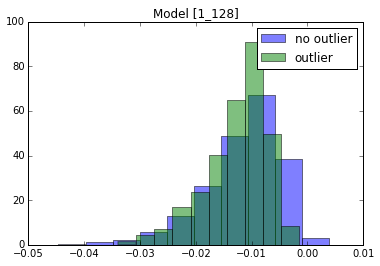

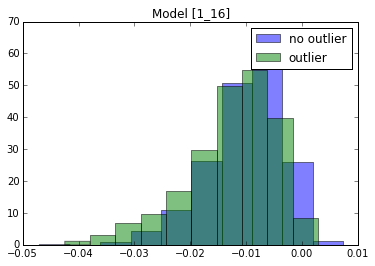

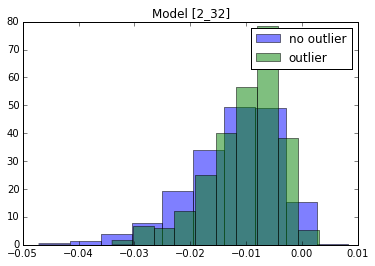

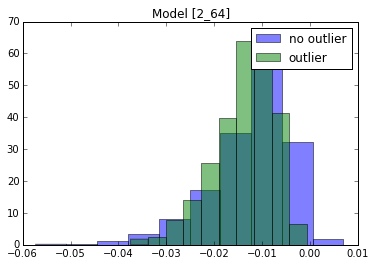

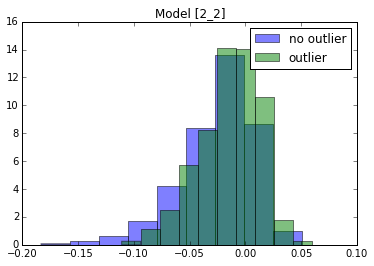

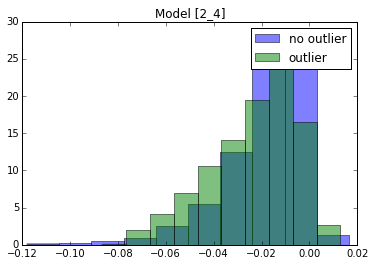

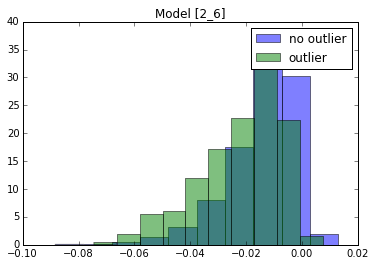

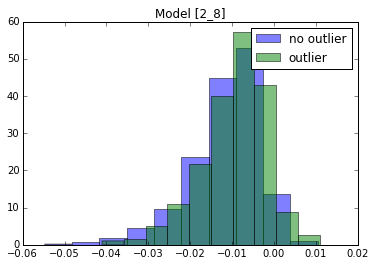

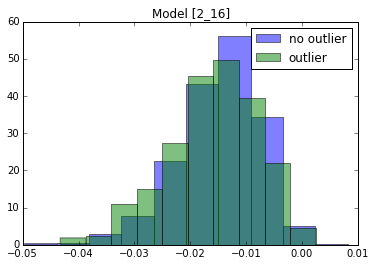

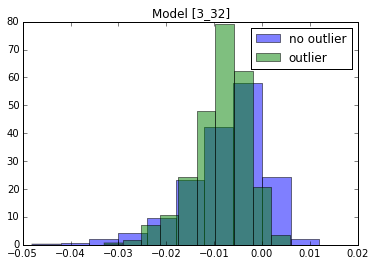

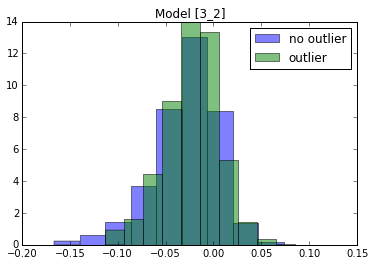

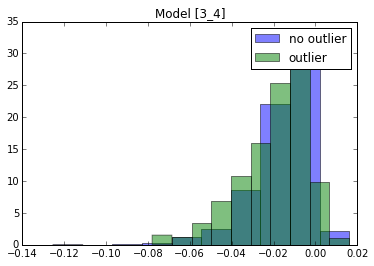

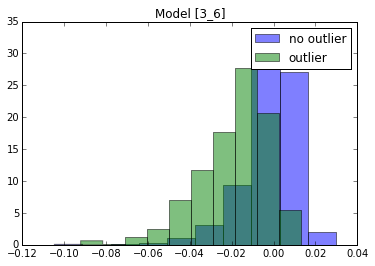

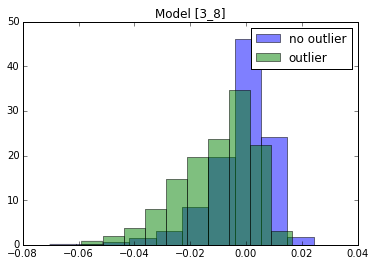

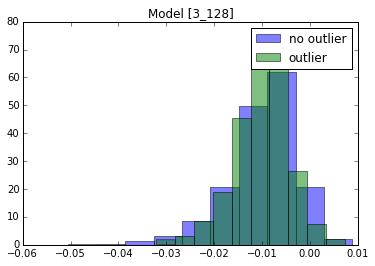

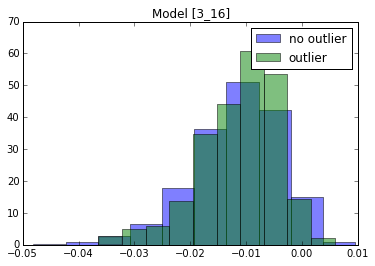

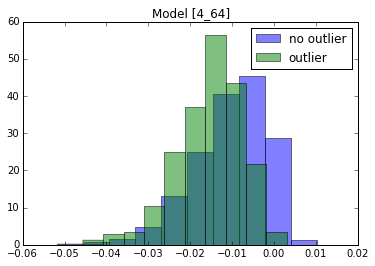

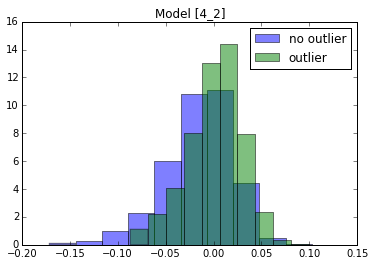

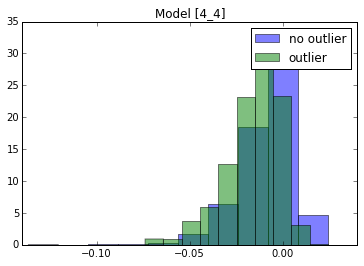

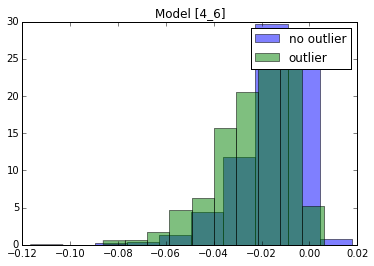

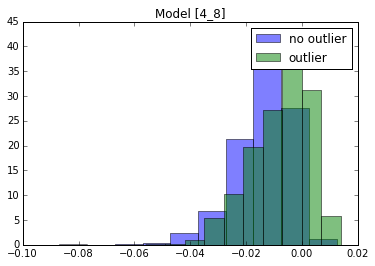

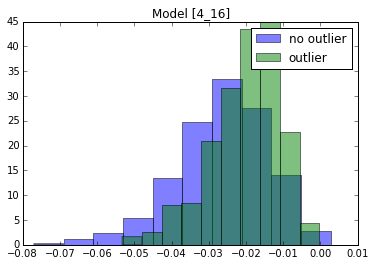

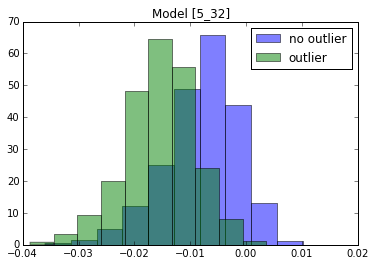

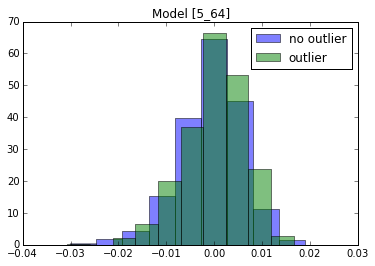

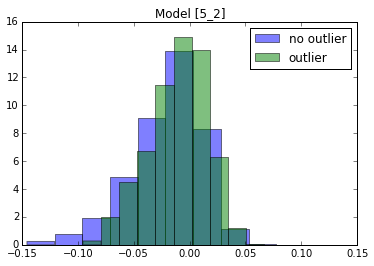

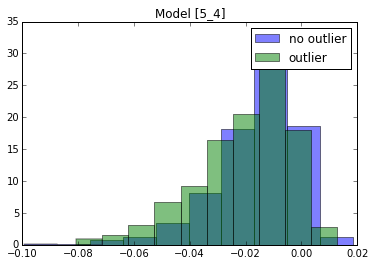

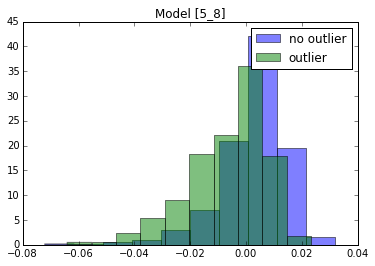

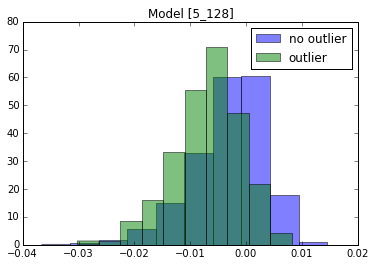

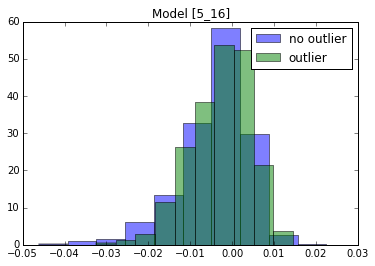

In [10]:
for layer, model in results.iteritems():
    for bottleneck in model:
        plt.hist( results[layer][bottleneck]['MDP'], alpha=0.5, label='no outlier', normed=1)
        plt.hist( results[layer][bottleneck]['MDP_outlier'], alpha=0.5, label='outlier',normed=1)
        plt.title('Model [%s_%s]' % (layer, bottleneck))
        plt.legend()
        plt.show()

Get scatter plots of digits for each model with 2 latent layers

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


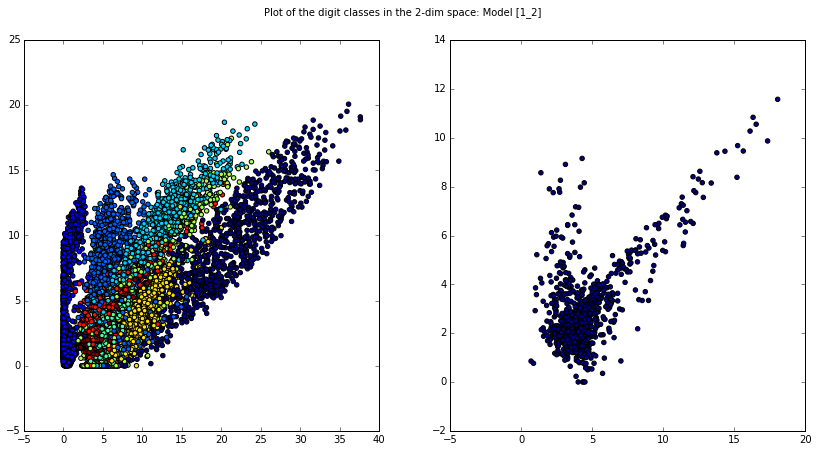

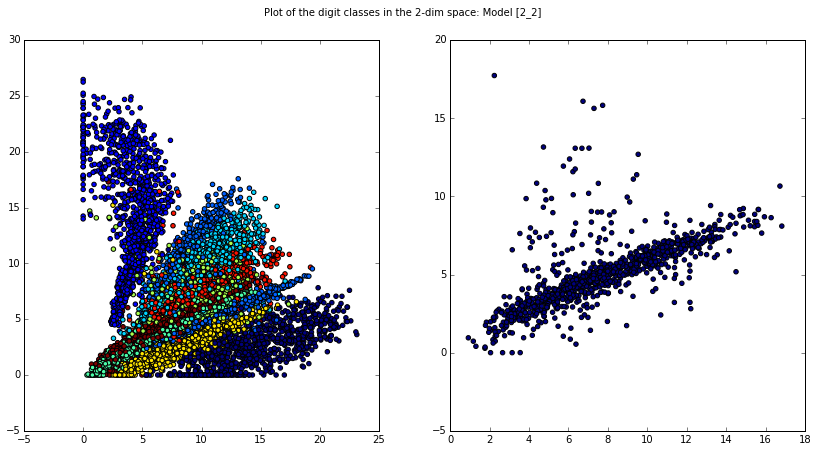

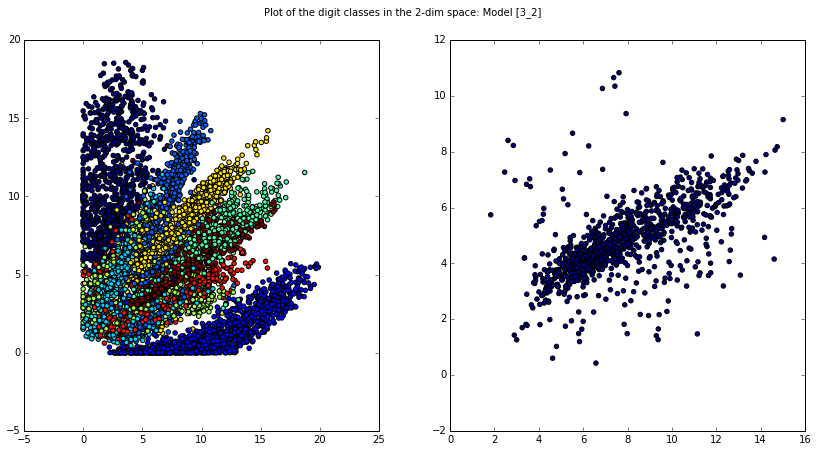

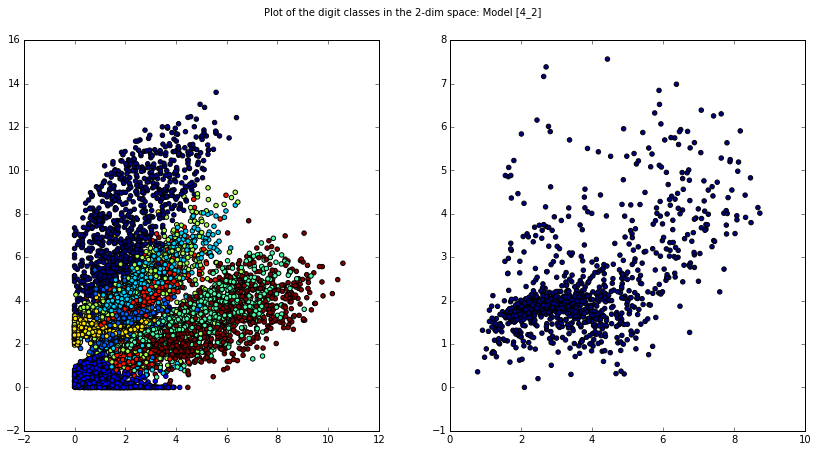

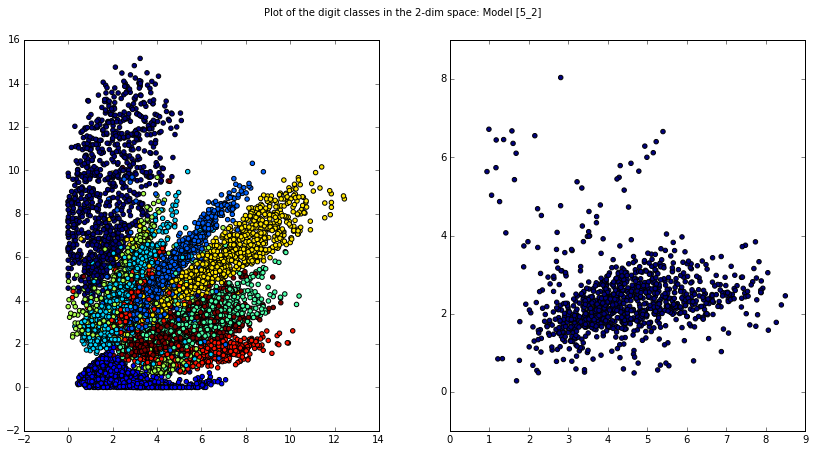

In [11]:
for layer, model in results.iteritems():
    x_test_encoded= results[layer][2]['Coder'].predict(x_test, batch_size=batch_size)
    x_test_outlier_encoded= results[layer][2]['Coder'].predict(x_test_outlier, batch_size=batch_size)
    fig1 = figure(FigureClass=MyFigure, figtitle='Plot of the digit classes in the 2-dim space: Model [%s_2]' % layer,figsize=(14, 7))
    b = fig1.add_subplot(1,2,1)
    b.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    c = fig1.add_subplot(1,2,2)
    c.scatter(x_test_outlier_encoded[:, 0], x_test_outlier_encoded[:, 1], c=y_test_outlier)
plt.show()

Show prediction for each model for outlier

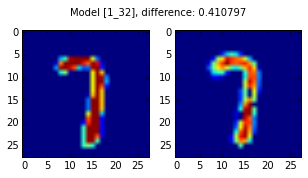

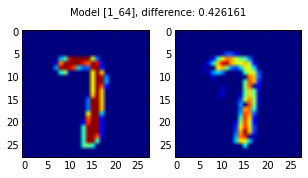

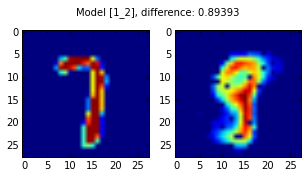

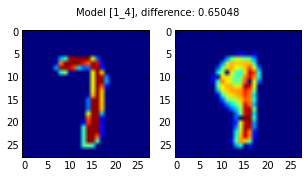

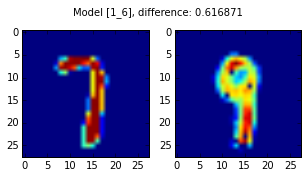

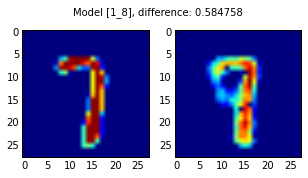

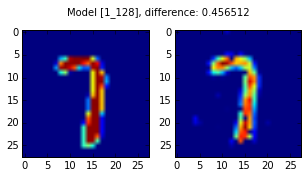

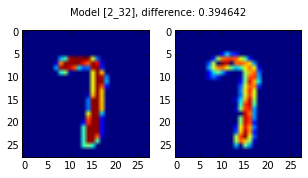

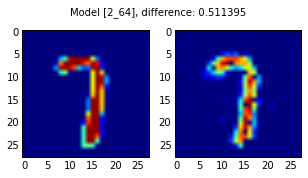

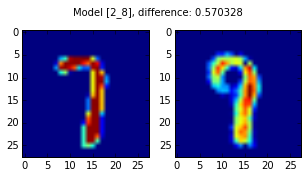

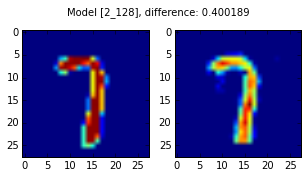

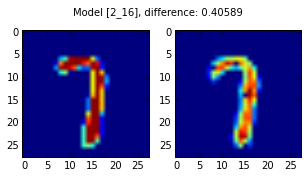

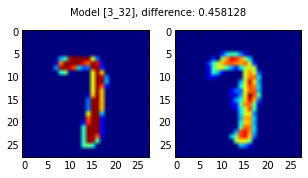

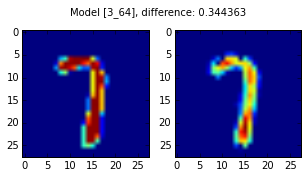

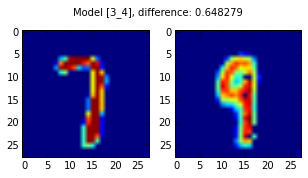

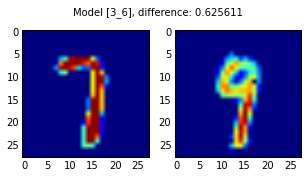

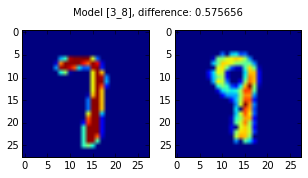

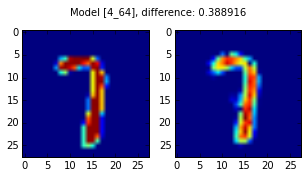

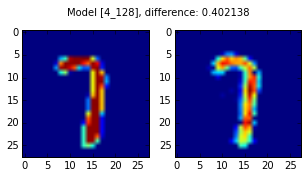

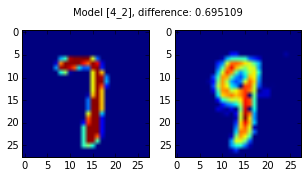

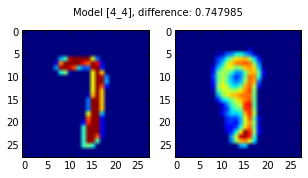

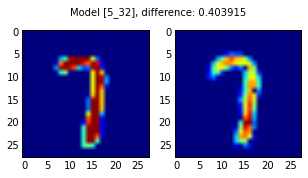

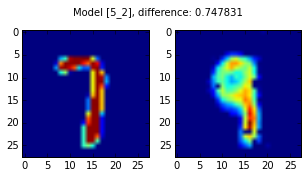

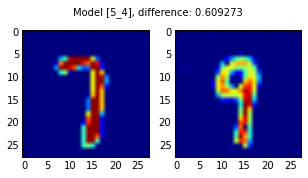

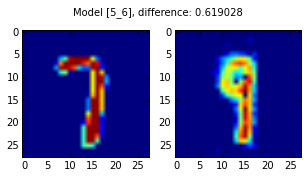

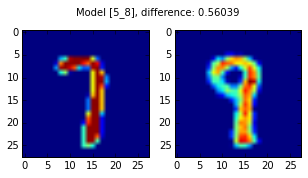

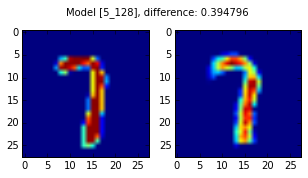

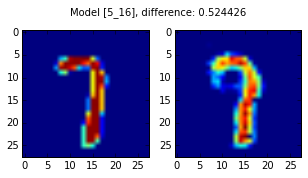

In [12]:
for layer, model in results.iteritems():
    for bottleneck in model:
        showOne(results[layer][bottleneck]['Autoencoder'], x_test_outlier[30],layer,bottleneck)

Define the best model (the minimun I/O difference in outlier digits)

In [13]:
minLayer = 0
minBottleneck = 0
minDifference = 100
number = x_test_outlier[30]
for layer, model in results.iteritems():
    for bottleneck in model:
        image = results[layer][bottleneck]['Autoencoder'].predict(number.reshape(1,784) )
        difference = IOdifference(number,image[0])
        if (minDifference > difference):
            minLayer = layer
            minBottleneck = bottleneck
            minDifference = difference
print 'Best model [%s_%s] with difference %s ' % (minLayer,minBottleneck,minDifference)

Best model [3_64] with difference 0.344363 


Show prediction for each model for test data

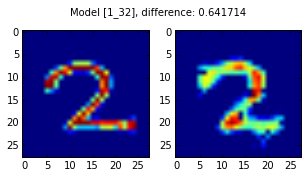

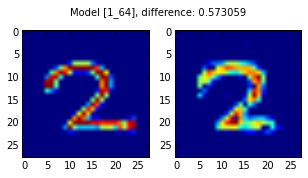

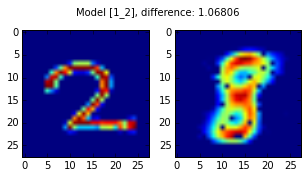

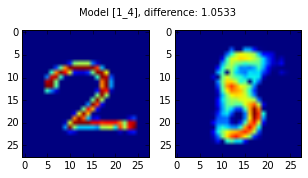

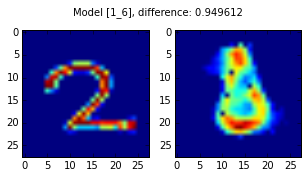

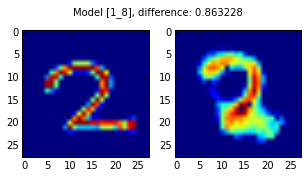

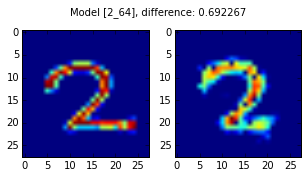

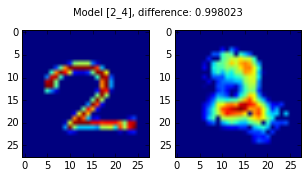

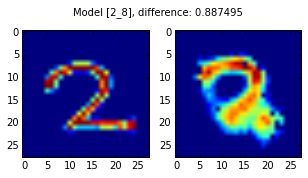

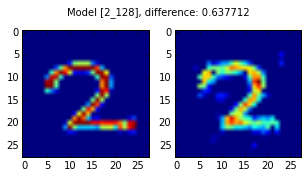

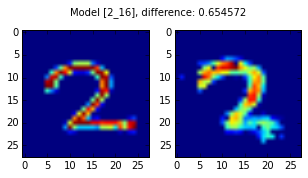

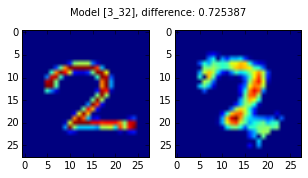

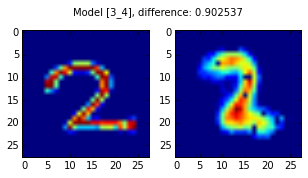

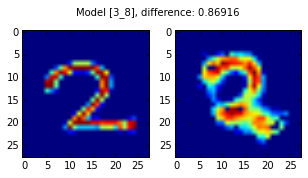

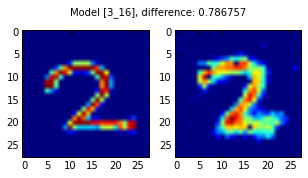

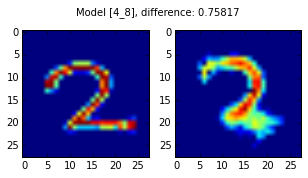

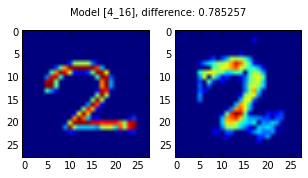

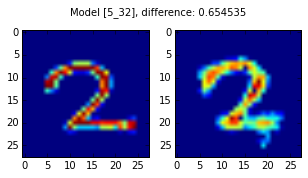

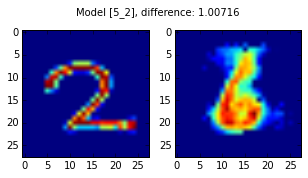

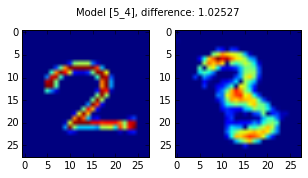

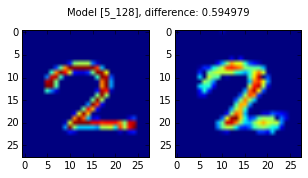

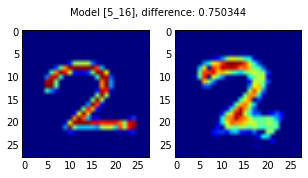

In [14]:
for layer, model in results.iteritems():
    for bottleneck in model:
        showOne(results[layer][bottleneck]['Autoencoder'], x_test[67],layer,bottleneck)

Define the best model (the minimun I/O difference in test digits)

In [15]:
minLayer = 0
minBottleneck = 0
minDifference = 100
number = x_test[67]
for layer, model in results.iteritems():
    for bottleneck in model:
        image = results[layer][bottleneck]['Autoencoder'].predict(number.reshape(1,784) )
        difference = IOdifference(number,image[0])
        if (minDifference > difference):
            minLayer = layer
            minBottleneck = bottleneck
            minDifference = difference
print 'Best model [%s_%s] with difference %s ' % (minLayer,minBottleneck,minDifference)

Best model [3_64] with difference 0.55332 


Plot digits along an appropriate direction

In [16]:
def plotAlongLine(x1,y1,x2,y2,coder,decoder):
    number_digits = 30
    digit_size = 28
    a = (float)(y2 - y1)/(x2 - x1)
    b = (float)(y2 - a*x2)
    x = np.linspace(x2, x1, number_digits)
    y = funcLine(a,b,x)
    x_test_encoded= coder.predict(x_test, batch_size=batch_size)
    plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c = y_test, color='black')  
    plt.colorbar(ticks=range(10))
    plt.plot(x,y,color='pink',linewidth = 3)
    plt.show()
    data = zip(x,y)
    x_test_decoded= decoder.predict(data, batch_size=batch_size) 
    fig = figure(FigureClass=MyFigure, figtitle='Along the line')
    for (e,i) in enumerate(x_test_decoded): 
        a = fig.add_subplot(5,6,e+1)
        a.imshow(i.reshape(digit_size,digit_size))
    plt.show()

Model [1_2]


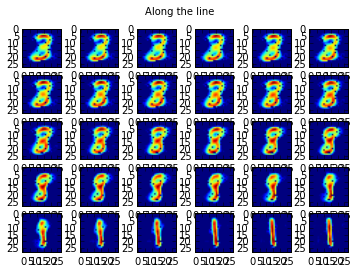

Model [2_2]


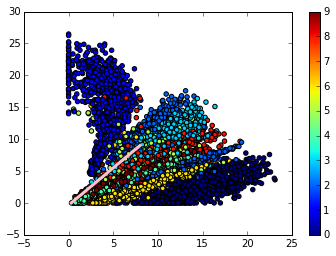

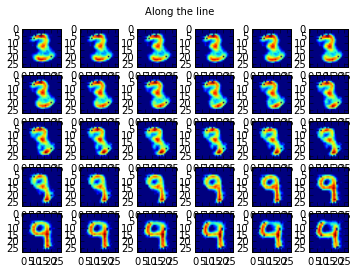

Model [3_2]


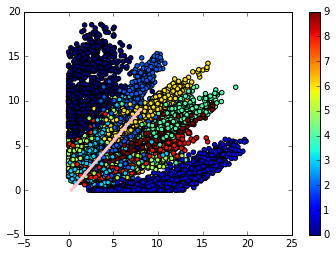

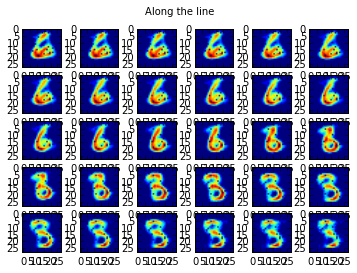

Model [4_2]


Model [5_2]


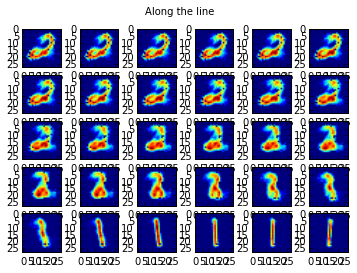

In [40]:
for layer, model in results.iteritems():
    print 'Model [%s_2]' % layer
    x1 = 0.3
    y1 = 0
    x2 = 8
    y2 = 9
    plotAlongLine(x1,y1,x2,y2,results[layer][2]['Coder'],results[layer][2]['Decoder'])

Plot digits around an appropriate point

In [18]:
def plotAroundPoint(center,r,autoencoder,coder,decoder):
    x_test_encoded= coder.predict(x_test, batch_size=batch_size)
    x0, y0 = x_test_encoded[center,:]
    number_digits = 30
    digit_size = 28
    t = np.linspace(0,2*np.pi,number_digits).reshape(number_digits,1)
    data = np.concatenate((x0+r*np.cos(t), y0+r*np.sin(t)),axis=1)
    plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c = y_test, color='black') 
    plt.colorbar(ticks=range(10))
    plt.plot(data[:,0],data[:,1],color='pink', linewidth = 3)
    plt.show()

    fig1 = figure(FigureClass=MyFigure, figtitle='Prediction',figsize=(5, 2.5))
    b = fig1.add_subplot(1,2,1)
    b.imshow(x_test[center,:].reshape(28,28))
    c = fig1.add_subplot(1,2,2)
    img = autoencoder.predict(x_test[center,:].reshape(1,784))
    c.imshow(img.reshape(28,28))
    plt.show()

    new_img = decoder.predict(data) 
    fig = figure(FigureClass=MyFigure, figtitle='Around the point')
    box=int(np.sqrt(number_digits))+1
    for (e,i) in enumerate(new_img): 
        a = fig.add_subplot(box,box,e+1)
        a.imshow(i.reshape(digit_size,digit_size))
    plt.show() 

Model [1_2]
0.7


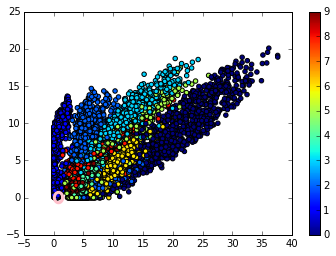

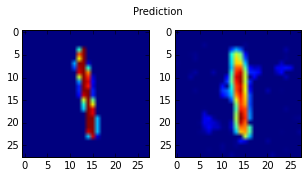

Model [2_2]
0.7


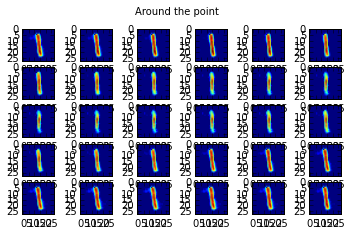

Model [3_2]
0.7


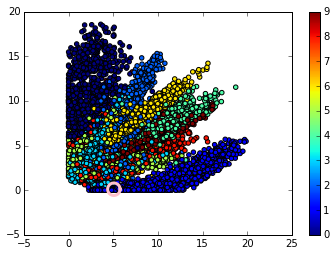

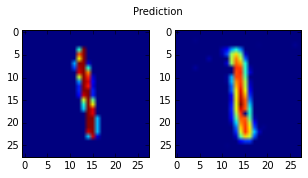

Model [4_2]
0.7


Model [5_2]
0.7


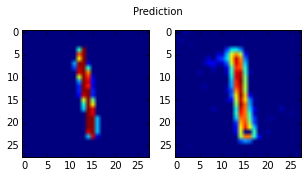

In [19]:
for layer, model in results.iteritems():
    print 'Model [%s_2]' % layer
    center = 123
    r = 0.7
    print r
    plotAroundPoint(center,r,results[layer][2]['Autoencoder'],results[layer][2]['Coder'],results[layer][2]['Decoder'])

Get accuracies plot

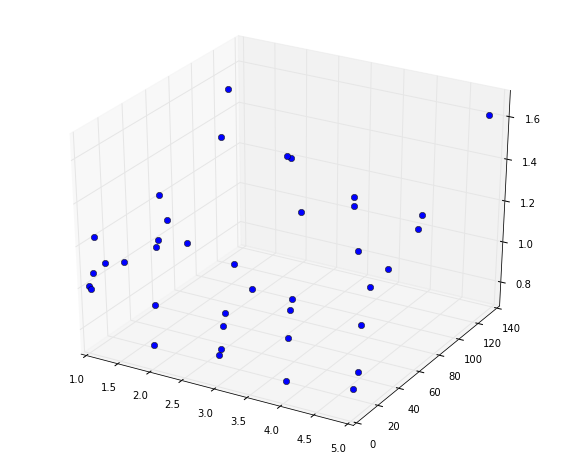

In [20]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(modelLayers,modelBottleneck,modelAcc,'bo')

Get plots for accuracy depending on bottleneck for models with different amount of layers

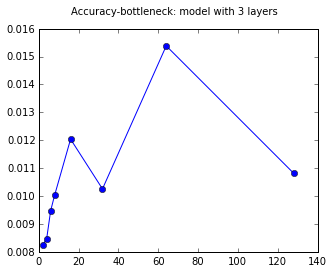

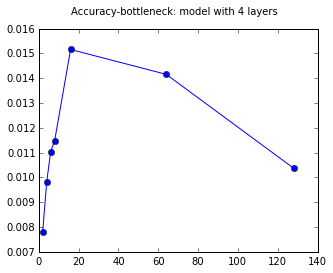

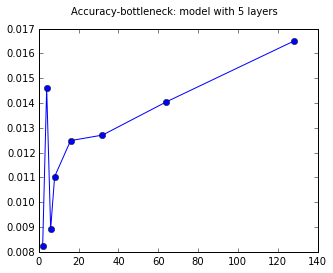

In [21]:
for layer, model in results.iteritems():
    Y = []
    X = []
    for bottleneck in model:
        y = results[layer][bottleneck]['Acc']
        Y.append(y)
        X.append(bottleneck)
    data = zip(X,Y)
    data.sort()
    Y = []
    X = []
    for i in range (len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])  
    figAcc = figure(FigureClass=MyFigure, figsize=(5, 4),figtitle='Accuracy-bottleneck: model with %s layers' % layer)
    ax = figAcc.add_subplot(1,1,1)
    ax.plot(X,Y)
    ax.plot(X,Y,'bo')

Get plots average MDP depending on the bottleneck value for models with different amount of layers

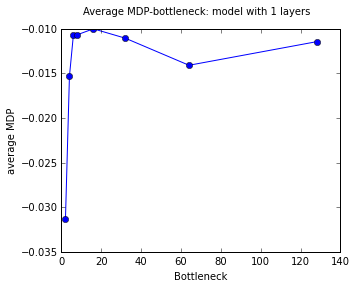

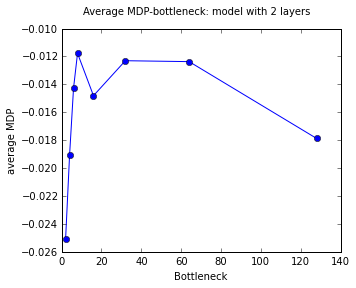

In [22]:
for layer, model in results.iteritems():
    Y = []
    X = []
    for bottleneck in model:
        y = results[layer][bottleneck]['MDP']
        y = np.mean(y)
        Y.append(y)
        X.append(bottleneck)
    data = zip(X,Y)
    data.sort()
    Y = []
    X = []
    for i in range (len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])  
    figAcc = figure(FigureClass=MyFigure, figsize=(5, 4),figtitle='Average MDP-bottleneck: model with %s layers' % layer)
    ax = figAcc.add_subplot(1,1,1)
    ax.plot(X,Y)
    ax.plot(X,Y,'bo')
    plt.xlabel('Bottleneck')
    plt.ylabel('average MDP')

Get plots for average MDP depending on number of layers for models with different bottleneck

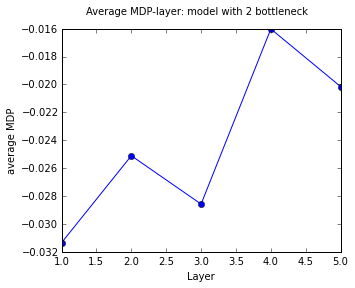

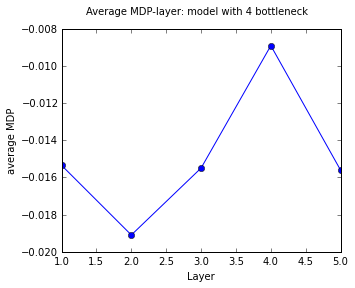

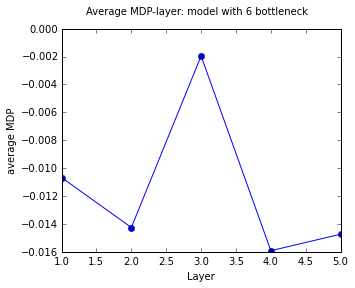

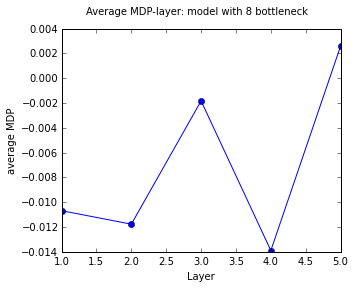

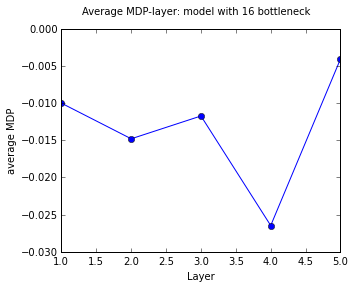

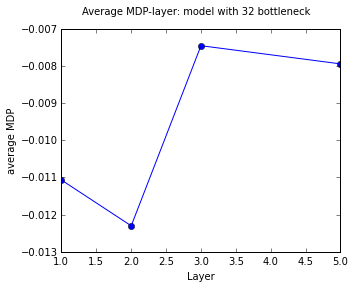

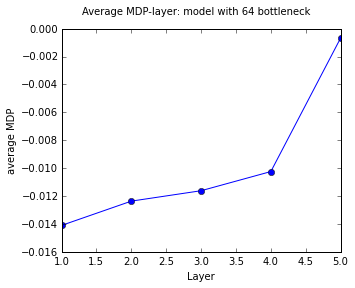

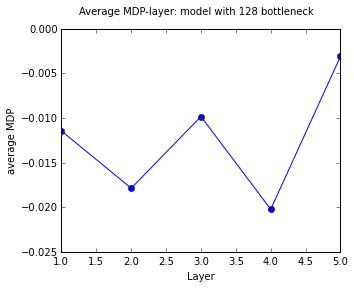

In [23]:
for nBottleneck in bottlenecks:
    Y = []
    X = []
    for nLayer in layers:
        if (nBottleneck == 32) and (nLayer == 4):
            continue
        else:  
            y = results[nLayer][nBottleneck]['MDP']
            y = np.mean(y)
            Y.append(y)
            X.append(nLayer)   
    figAcc = figure(FigureClass=MyFigure, figsize=(5, 4),figtitle='Average MDP-layer: model with %s bottleneck' % nBottleneck)
    ax = figAcc.add_subplot(1,1,1)
    ax.plot(X,Y)  
    ax.plot(X,Y,'bo') 
    plt.xlabel('Layer')
    plt.ylabel('average MDP')

In [36]:
maxLayer = 0
maxBottleneck = 0
maxDifference = 0
number = x_test_outlier[30]
for layer, model in results.iteritems():
    for bottleneck in model:
        image = results[layer][bottleneck]['Autoencoder'].predict(number.reshape(1,784) )
        difference = IOdifference(number,image[0])
        if (maxDifference < difference):
            maxLayer = layer
            maxBottleneck = bottleneck
            maxDifference = difference
print 'Best model [%s_%s] with difference %s ' % (maxLayer,maxBottleneck,maxDifference)

Best model [2_2] with difference 0.944811 


In [37]:
maxLayer = 0
maxBottleneck = 0
maxDifference = 0
number = x_test[30]
for layer, model in results.iteritems():
    for bottleneck in model:
        image = results[layer][bottleneck]['Autoencoder'].predict(number.reshape(1,784) )
        difference = IOdifference(number,image[0])
        if (maxDifference < difference):
            maxLayer = layer
            maxBottleneck = bottleneck
            maxDifference = difference
print 'Best model [%s_%s] with difference %s ' % (maxLayer,maxBottleneck,maxDifference)

Best model [1_2] with difference 1.08178 


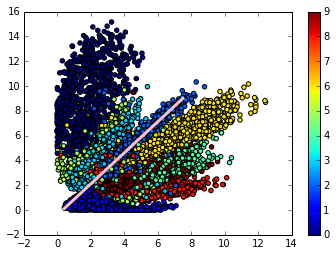

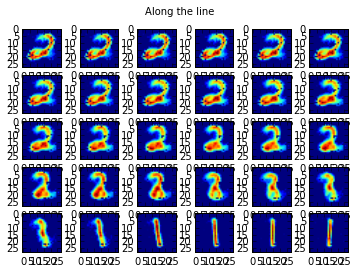

In [45]:
x1 = 0.4
y1 = 0.1
x2 = 7.5
y2 = 9
plotAlongLine(x1,y1,x2,y2,results[5][2]['Coder'],results[5][2]['Decoder'])

0.3


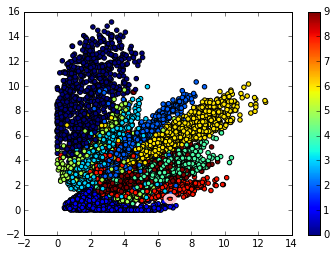

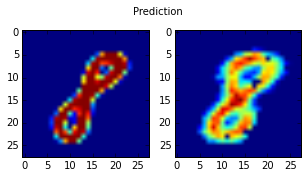

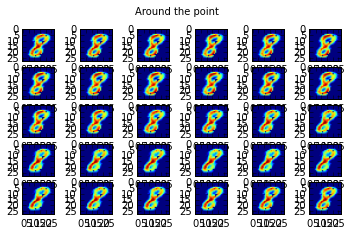

In [99]:
center = 8006
#71, 176, 219, 383, 634, 635, 637, 665, 688, 689, 690, 691, 692,
#       694, 808, 836, 936, 940
r = 0.3
print r
plotAroundPoint(center,r,results[5][2]['Autoencoder'],results[5][2]['Coder'],results[5][2]['Decoder'])

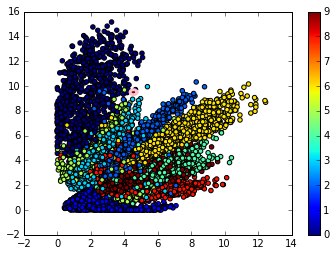

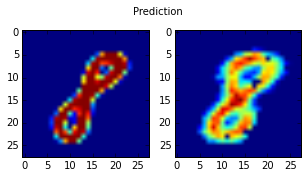

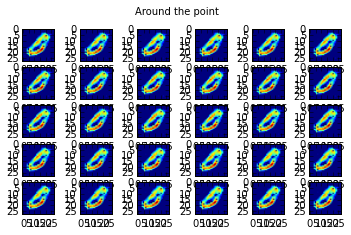

In [109]:
x_test_encoded= results[5][2]['Coder'].predict(x_test, batch_size=batch_size)
x0, y0 = x_test_encoded[center,:]
x0 = 4.55
y0 = 9.5
r= 0.2
number_digits = 30
digit_size = 28
t = np.linspace(0,2*np.pi,number_digits).reshape(number_digits,1)
data = np.concatenate((x0+r*np.cos(t), y0+r*np.sin(t)),axis=1)
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c = y_test, color='black') 
plt.colorbar(ticks=range(10))
plt.plot(data[:,0],data[:,1],color='pink', linewidth = 3)
plt.show()

fig1 = figure(FigureClass=MyFigure, figtitle='Prediction',figsize=(5, 2.5))
b = fig1.add_subplot(1,2,1)
b.imshow(x_test[center,:].reshape(28,28))
c = fig1.add_subplot(1,2,2)
img = results[5][2]['Autoencoder'].predict(x_test[center,:].reshape(1,784))
c.imshow(img.reshape(28,28))
plt.show()

new_img = results[5][2]['Decoder'].predict(data) 
fig = figure(FigureClass=MyFigure, figtitle='Around the point')
box=int(np.sqrt(number_digits))+1
for (e,i) in enumerate(new_img): 
    a = fig.add_subplot(box,box,e+1)
    a.imshow(i.reshape(digit_size,digit_size))
plt.show() 